# 🧠 Laboratorio 5 – Classificatori Lineari: Percettrone, Least Squares e Gaussian Discriminant Analysis

**Corso:** Machine Learning – Laurea Magistrale in Informatica  
**Università:** Roma “Tor Vergata”  
**Docenti:** Danilo Croce, Giorgio Gambosi  

---

## 🎯 Obiettivo del laboratorio

In questo laboratorio esploriamo **tre approcci fondamentali alla classificazione lineare**, ciascuno con una diversa prospettiva teorica e geometrica:

| Modello | Tipo | Idea principale |
|----------|------|-----------------|
| **Percettrone** | *Discriminativo* | Trova un iperpiano che separa linearmente due classi aggiornando iterativamente i pesi. |
| **Least Squares** | *Discriminativo (analitico)* | Riutilizza la regressione lineare per la classificazione, minimizzando un errore ai minimi quadrati. |
| **Gaussian Discriminant Analysis (GDA)** | *Generativo (probabilistico)* | Assume che ogni classe provenga da una distribuzione gaussiana e usa il teorema di Bayes per classificare. |

---

## 🧩 Panoramica concettuale

Tutti e tre i metodi cercano un **confine decisionale lineare**:
$$
w^T x + w_0 = 0
$$

ma differiscono nel **modo in cui determinano** i parametri $ w $ e $ w_0 $:

- Il **Percettrone** corregge iterativamente gli errori di classificazione (approccio numerico).  
- Il **Least Squares** li calcola risolvendo un sistema lineare (approccio analitico).  
- La **GDA** li deduce stimando le distribuzioni di probabilità di ciascuna classe (approccio probabilistico).

---

## ⚖️ Obiettivi pratici del laboratorio

1. Implementare e visualizzare il comportamento del **Percettrone**, inclusa la direzione del gradiente e la stabilità durante l’apprendimento.  
2. Derivare e applicare il metodo dei **Minimi Quadrati per la classificazione**, confrontandone la robustezza.  
3. Costruire un **modello probabilistico generativo (GDA)**, mostrando la relazione con il confine lineare e la distribuzione gaussiana sottostante.  
4. **Confrontare visivamente** i tre approcci e discutere differenze e interpretazioni geometriche.

---

## 🔧 Prerequisiti

Per affrontare il laboratorio sono richieste conoscenze di base su:
- Algebra lineare (prodotti scalari, matrici e autovalori)  
- Regressione lineare e pseudoinversa  
- Distribuzioni gaussiane multivariate  
- Regola di Bayes e concetto di probabilità condizionata  

---

## 📘 Struttura del notebook

1. **Percettrone:** classificatore lineare iterativo  
2. **Least Squares:** classificatore analitico basato su regressione  
3. **Gaussian Discriminant Analysis:** modello generativo probabilistico  
4. **Confronto finale e discussione**

---

💡 Alla fine del laboratorio dovresti:
- Comprendere come modelli diversi portano allo **stesso tipo di confine lineare**, ma con **motivazioni teoriche differenti**;  
- Saper implementare ciascun approccio in Python;  
- Visualizzare e interpretare geometricamente i risultati.

---

## 📂 Caricamento e visualizzazione del dataset

In questa sezione carichiamo un dataset di esempio per la **classificazione binaria**, disponibile online al link:

> [https://tvml.github.io/ml2425/dataset/ex2data1.txt](https://tvml.github.io/ml2425/dataset/ex2data1.txt)

Il dataset contiene tre colonne:
- `x1`, `x2`: le **feature** numeriche (due dimensioni per semplicità di visualizzazione);
- `t`: la **classe** di appartenenza (`0` o `1`).

Dopo il caricamento, i dati verranno rappresentati graficamente nel piano $(x_1, x_2)$ per osservare la **separabilità lineare** delle due classi.

File ‘ex2data1.txt’ already there; not retrieving.

📊 Prime osservazioni del dataset:


,x1,x2,t
0,30.286711,43.894998,0
1,35.847409,72.902198,0
2,60.182599,86.308552,1
3,79.032736,75.344376,1
4,45.083277,56.316372,0



Numero di campioni: 99
              x1         x2          t
count  99.000000  99.000000  99.000000
mean   65.957614  66.102779   0.606061
std    19.302009  18.638875   0.491108
min    30.058822  30.603263   0.000000
25%    51.297736  47.978125   0.000000
50%    67.319257  66.589353   1.000000
75%    80.234877  79.876423   1.000000
max    99.827858  98.869436   1.000000


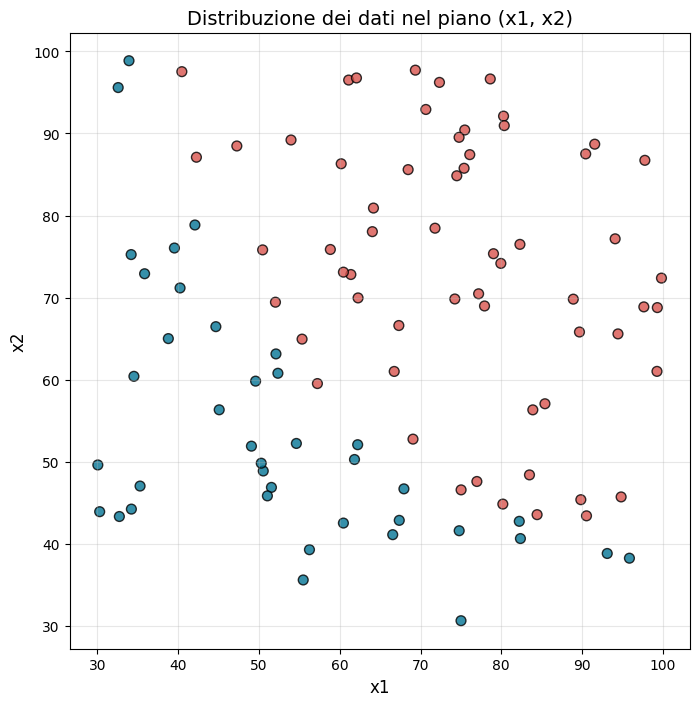

In [ ]:
# ============================================================
# 📥 Caricamento e ispezione del dataset
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

# Scarica il dataset (se non già presente)
!wget -nc https://tvml.github.io/ml2425/dataset/ex2data1.txt

# Legge il file CSV con pandas
data = pd.read_csv("ex2data1.txt", header=0, delimiter=',', names=['x1', 'x2', 't'])

# Mostra le prime righe del dataset
print("📊 Prime osservazioni del dataset:")
display(data.head())

# Dimensione e statistiche di base
print(f"\nNumero di campioni: {len(data)}")
print(data.describe())

# Estrae feature e target
X = data[['x1', 'x2']].values
t = data['t'].values.reshape(-1, 1)

# Normalizza le feature (media 0, varianza 1)
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0, ddof=1)
X_norm = (X - X_mean) / X_std

# Aggiunge il bias (-1) come prima colonna
X_aug = np.column_stack((-np.ones(len(X_norm)), X_norm))

# ============================================================
# 🎨 Visualizzazione delle due classi nel piano (x1, x2)
# ============================================================

colors = ['xkcd:sea blue', 'xkcd:pale red']
c = [colors[i] for i in data['t']]

plt.figure(figsize=(8, 8))
plt.scatter(data['x1'], data['x2'], c=c, edgecolor='k', alpha=0.8, s=50)
plt.title("Distribuzione dei dati nel piano (x1, x2)", fontsize=14)
plt.xlabel("x1", fontsize=12)
plt.ylabel("x2", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

**prima di iniziare... il diavolo è nei dettagli...**

## ⚖️ Normalizzazione dei dati

Prima di applicare qualsiasi metodo di classificazione (Least Squares, Perceptron, o GDA),
è importante **normalizzare i dati di input**.

La normalizzazione (spesso chiamata *feature scaling*) consiste nel riportare tutte le variabili
sullo **stesso ordine di grandezza**, ad esempio con media 0 e varianza 1.

### 🔍 Perché è importante?

- Evita che una feature con valori grandi (es. “età in anni”) domini su un’altra
  con valori piccoli (es. “rapporto altezza/peso”).
- Rende la geometria del problema più “equilibrata”, in modo che il confine decisionale
  (come $w^\top x + b = 0$) **dipenda dal contenuto informativo** e non dalle scale numeriche.
- Facilita la convergenza di algoritmi iterativi (come il Percettrone o la Regressione Logistica).
- Nel caso del modello bayesiano o dei minimi quadrati, migliora la **stabilità numerica**
  dell’inversione di matrici (es. $(X^\top X)^{-1}$).

### 💡 Nota pratica

Nel codice, la normalizzazione è già stata eseguita in precedenza e salvata in:
```python
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
```
Tutti i modelli successivi — incluso il Least Squares per la classificazione —
utilizzeranno queste feature normalizzate.

# 🧮 Classificazione tramite Minimi Quadrati (Least Squares)

In questa sezione esploriamo un approccio alternativo al Percettrone: la **classificazione con minimi quadrati**, o *Least Squares for Classification*.

L’idea nasce dal riutilizzare la formulazione della **regressione lineare**, minimizzando una funzione di errore ai minimi quadrati:

$$
E_D(W) = \frac{1}{2} \mathrm{Tr}\left[(XW - T)^T (XW - T)\right]
$$

dove:
- $ X $ è la matrice dei dati di input (ogni riga è un campione, con un termine di bias incluso),
- $ T $ è la matrice dei **target**, rappresentati in codifica *1-of-K*,
- $ W $ è la matrice dei **coefficienti** da stimare.

---

## 🔹 Soluzione in forma chiusa

Come per la regressione lineare, possiamo derivare una **soluzione analitica** minimizzando l’errore rispetto a $ W $:

$$
W = (X^T X)^{-1} X^T T = X^{\dagger} T
$$

dove $ X^{\dagger} $ è la *pseudoinversa* di Moore-Penrose.

---

## 🔹 Decisione di classe

Una volta stimato $ W $, la predizione per un nuovo punto $ x $ si ottiene come:

$$
y(x) = W^T x
$$

Il punto viene assegnato alla **classe** per cui l’output $ y_k(x) $ è massimo:

$$
\hat{C}(x) = \arg\max_k y_k(x)
$$

---

## ⚠️ Limiti del metodo

Questo approccio, pur avendo una **soluzione esatta e semplice**, soffre di alcune **limitazioni importanti**:
- i valori di $ y(x) $ non sono vincolati tra (0, 1), quindi **non possono essere interpretati come probabilità**;
- è **molto sensibile agli outlier**, perché i punti lontani influenzano fortemente la stima dei pesi;
- penalizza anche i punti “troppo corretti”, cioè quelli molto lontani dal confine decisionale.

---

Nel seguito, applichiamo questo metodo sullo **stesso dataset** del Percettrone per confrontarne i risultati 👇

📘 Prime righe di X_ls (incluso il bias):
   bias  x1_norm  x2_norm
0   1.0   -1.848   -1.191
1   1.0   -1.560    0.365
2   1.0   -0.299    1.084
3   1.0    0.677    0.496
4   1.0   -1.081   -0.525

🎯 Prime righe della matrice T (target 1-of-K):
   Classe 0  Classe 1
0         1         0
1         1         0
2         0         1
3         0         1
4         1         0

✅ Accuracy (Least Squares): 0.899
📐 Matrice dei pesi W:
[[ 0.39393939  0.60606061]
 [-0.28144594  0.28144594]
 [-0.26178388  0.26178388]]


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


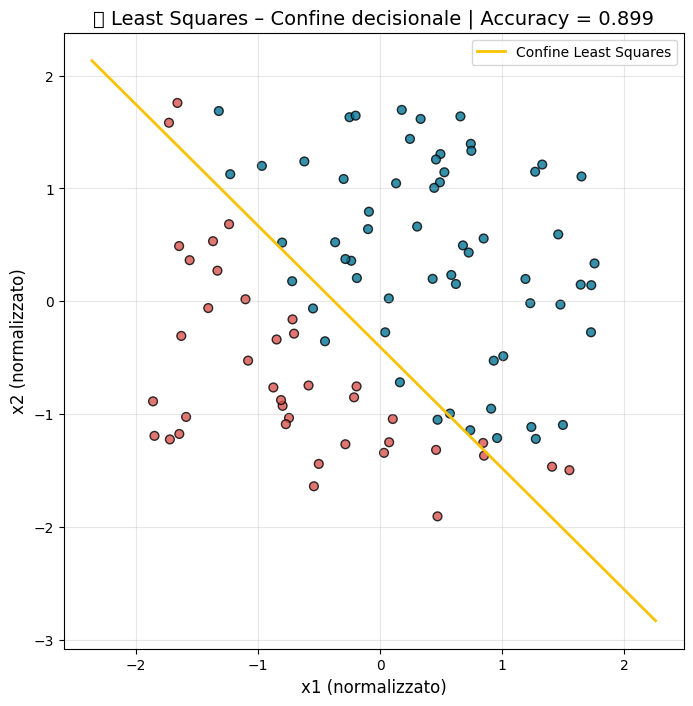

In [ ]:
# ============================================================
# 📘 Classificazione lineare con Minimi Quadrati (Least Squares)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ Preparazione dei dati
# ------------------------------------------------------------
X_ls = np.column_stack((np.ones(len(X_norm)), X_norm))  # aggiunge bias = +1
y_ls = t.ravel()  # vettore target (0 o 1)

# Mostra alcune righe della matrice di input
print("📘 Prime righe di X_ls (incluso il bias):")
print(pd.DataFrame(X_ls[:5], columns=["bias", "x1_norm", "x2_norm"]).round(3))
print()

# Codifica "1-of-K" (qui solo due classi)
T = np.zeros((len(y_ls), 2))
for i in range(len(y_ls)):
    T[i, int(y_ls[i])] = 1

# Mostra alcune righe della matrice target
print("🎯 Prime righe della matrice T (target 1-of-K):")
print(pd.DataFrame(T[:5], columns=["Classe 0", "Classe 1"]).astype(int))
print()

# ------------------------------------------------------------
# 2️⃣ Calcolo analitico dei pesi W = (XᵀX)⁻¹ XᵀT
# ------------------------------------------------------------
W = np.linalg.inv(X_ls.T @ X_ls) @ X_ls.T @ T

# Predizione continua (non limitata in [0,1])
Y_pred = X_ls @ W
y_class = np.argmax(Y_pred, axis=1)

# Accuracy
acc_ls = np.mean(y_class == y_ls)
print(f"✅ Accuracy (Least Squares): {acc_ls:.3f}")
print("📐 Matrice dei pesi W:")
print(W)

# ------------------------------------------------------------
# 3️⃣ Confine decisionale
# ------------------------------------------------------------
# Una volta stimati i pesi W, possiamo ricavare la frontiera di decisione
# tra le due classi. Ogni colonna di W corrisponde a una classe:
#
#   W = [[w₀₁, w₀₂],      ← bias (termini costanti)
#        [w₁₁, w₁₂],      ← coefficienti per la feature x₁
#        [w₂₁, w₂₂]]      ← coefficienti per la feature x₂
#
# Ogni classe k ha quindi una funzione discriminante lineare:
#
#   yₖ(x) = w₀ₖ + w₁ₖ·x₁ + w₂ₖ·x₂ = wₖᵀ·x + w₀ₖ
#
# Il modello decide la classe con yₖ(x) più alto:
#   Classe(x) = argmax_k [ yₖ(x) ]
#
# ➜ Il confine decisionale è il luogo dei punti dove il modello
#     è "indeciso" tra le due classi, cioè dove y₁(x) = y₂(x).
#
# Sostituendo le due funzioni:
#     w₁ᵀ·x + w₀₁ = w₂ᵀ·x + w₀₂
#
# Portando tutto da una parte otteniamo:
#     (w₁ - w₂)ᵀ·x + (w₀₁ - w₀₂) = 0
#
# Questa è l’equazione del confine lineare (retta o iperpiano)
# tra le due classi: i punti x che la soddisfano sono quelli
# in cui il modello è esattamente al 50%.

# ------------------------------------------------------------
# Differenza tra i pesi e tra i bias
# ------------------------------------------------------------
# Ogni colonna di W rappresenta i parametri di una classe.
# La prima riga (indice 0) contiene i bias w₀ₖ,
# mentre le righe successive contengono i coefficienti (w₁ₖ, w₂ₖ, ...).
#
# Calcoliamo quindi la differenza tra i parametri delle due classi:
# (w_diff) corrisponde a (w₁ - w₂)
# (b_diff) corrisponde a (w₀₁ - w₀₂)
#
# Questi due valori definiscono la retta:
#     w_diffᵀ·x + b_diff = 0

w_diff = W[1:, 1] - W[1:, 0]   # differenza tra i coefficienti (vettore ortogonale al confine)
b_diff = W[0, 1] - W[0, 0]     # differenza tra i bias (spostamento del confine)

# ------------------------------------------------------------
# Costruisce la retta di separazione nel piano (x₁, x₂)
# ------------------------------------------------------------
# Dalla formula:
#     w₁·x₁ + w₂·x₂ + b = 0
# possiamo ricavare x₂ in funzione di x₁:
#
#     x₂ = - (w₁·x₁ + b) / w₂
#
# In questo modo possiamo tracciare la retta nel piano.

x_min, x_max = X_norm[:, 0].min() - 0.5, X_norm[:, 0].max() + 0.5
xx = np.linspace(x_min, x_max, 100)
yy = -(w_diff[0] * xx + b_diff) / w_diff[1]

# Ora (xx, yy) rappresenta la retta di separazione
# tra la Classe 0 e la Classe 1.

# ------------------------------------------------------------
# 4️⃣ Visualizzazione dei risultati
# ------------------------------------------------------------
plt.figure(figsize=(8, 8))

# Colori per classi
c = [colors[int(i)] for i in y_ls]

plt.scatter(X_norm[:, 0], X_norm[:, 1], c=c, s=40, edgecolor='k', alpha=0.8)
plt.plot(xx, yy, color='xkcd:goldenrod', linewidth=2, label='Confine Least Squares')

plt.xlabel("x1 (normalizzato)", fontsize=12)
plt.ylabel("x2 (normalizzato)", fontsize=12)
plt.title(f"🧮 Least Squares – Confine decisionale | Accuracy = {acc_ls:.3f}", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 💡 Interpretazione geometrica del gradiente e del confine lineare

Il confine decisionale del classificatore lineare (Percettrone, Least Squares o GDA)  
ha sempre la forma:

$$
w^T x + w_0 = 0
$$

In due dimensioni, con $x = [x_1, x_2]^T$, diventa:

$$
w_1 x_1 + w_2 x_2 + w_0 = 0.
$$

Questa è l’equazione di una **retta**. Possiamo riscriverla nella forma familiare:

$$
x_2 = -\frac{w_1}{w_2} x_1 - \frac{w_0}{w_2},
$$

cioè nella forma **y = m x + b**, dove:

- la **pendenza** è $ m = -\frac{w_1}{w_2} $;  
- l’**intercetta** è $ b = -\frac{w_0}{w_2} $.

---

### 🧭 Il ruolo del gradiente

Il vettore dei pesi $ w = [w_1, w_2]^T $ è **perpendicolare** al confine decisionale.

Perché?  
La retta (o il piano in generale) è definita dai punti $ x $ che soddisfano $ w^T x + w_0 = 0 $.  
Il gradiente di questa funzione rispetto a $ x $ è proprio $ \nabla_x (w^T x + w_0) = w $.  
Essendo il gradiente **ortogonale alle linee di livello costante**,  
segue che **$ w $** è perpendicolare alla retta decisionale.

---

### 📏 Margine funzionale e margine geometrico

Per un punto $ x_i $ con etichetta $ t_i \in \{-1, +1\} $:

- il **margine funzionale** è  
  $$
  \gamma_i = t_i (w^T x_i + w_0)
  $$

- il **margine geometrico** (cioè la distanza ortogonale dal piano) è  
  $$
  \hat{\gamma}_i = \frac{t_i (w^T x_i + w_0)}{\|w\|}
  $$

💡 Quindi:
- il *segno* di $ \gamma_i $ dice se il punto è nel lato giusto;  
- il *valore assoluto* di $ \hat{\gamma}_i $ dice **quanto è lontano** dal confine.

Nel grafico seguente vediamo visivamente questi concetti.

📘 EQUAZIONE DEL CONFINE DECISIONALE (forma implicita):
   0.563 * x1 + 0.524 * x2 + 0.212 = 0

📐 FORMA ESPLICITA DELLA RETTA (y = m x + b):
   x2 = (-1.075) * x1 + (-0.405)

👉 Pendenza (m): -1.075
👉 Intercetta (b): -0.405

🧭 INTERPRETAZIONE DEL GRADIENTE:
   Il gradiente della funzione f(x1, x2) = w1*x1 + w2*x2 + w0 è:
   ∇f = [w1, w2] = [0.563, 0.524]
   Questo vettore è perpendicolare alla retta di decisione.
   La sua direzione indica il lato in cui cresce f(x), cioè dove il modello predice la Classe 1.



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


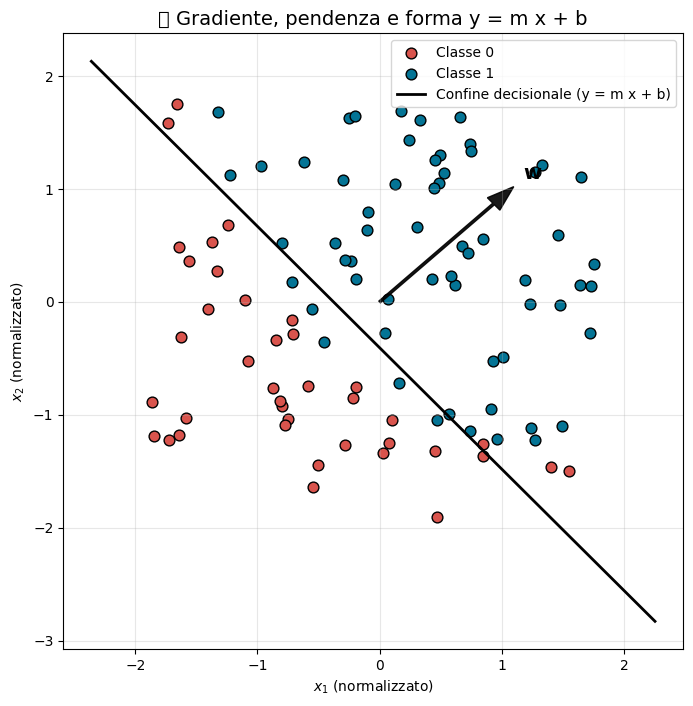

📊 RIEPILOGO:
• Confine decisionale (implicito): 0.563·x1 + 0.524·x2 + 0.212 = 0
• Forma esplicita: x2 = -1.075·x1 + -0.405
• Gradiente (direzione ortogonale): w = [0.563, 0.524]
• Direzione unitaria di w: [0.732 0.681]
• Il gradiente è perpendicolare al confine e punta verso il lato predetto come Classe 1.

📏 MARGINE FUNZIONALE E GEOMETRICO (esempio su un punto):
Per il punto x = [-1.848 -1.191] (t = -1):
• Margine funzionale γ = 1.452
• Margine geometrico γ̂ = 1.889


In [ ]:
# ============================================================
# 🎯 Interpretazione geometrica del gradiente e della retta y = m x + b
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ Recupero dei coefficienti dal modello Least Squares
# ------------------------------------------------------------
# w_diff e b_diff sono già calcolati nel blocco precedente
w1, w2 = w_diff[0], w_diff[1]
w0 = b_diff

print("📘 EQUAZIONE DEL CONFINE DECISIONALE (forma implicita):")
print(f"   {w1:.3f} * x1 + {w2:.3f} * x2 + {w0:.3f} = 0")
print()

# ------------------------------------------------------------
# 2️⃣ Trasformazione nella forma esplicita y = m x + b
# ------------------------------------------------------------
# Dalla formula: x2 = - (w1 / w2) * x1 - (w0 / w2)
m = -w1 / w2
b = -w0 / w2

print("📐 FORMA ESPLICITA DELLA RETTA (y = m x + b):")
print(f"   x2 = ({m:.3f}) * x1 + ({b:.3f})")
print()
print("👉 Pendenza (m):", round(m, 3))
print("👉 Intercetta (b):", round(b, 3))
print()

# ------------------------------------------------------------
# 3️⃣ Significato geometrico del gradiente
# ------------------------------------------------------------
print("🧭 INTERPRETAZIONE DEL GRADIENTE:")
print("   Il gradiente della funzione f(x1, x2) = w1*x1 + w2*x2 + w0 è:")
print(f"   ∇f = [w1, w2] = [{w1:.3f}, {w2:.3f}]")
print("   Questo vettore è perpendicolare alla retta di decisione.")
print("   La sua direzione indica il lato in cui cresce f(x), cioè dove il modello predice la Classe 1.")
print()

# ------------------------------------------------------------
# 4️⃣ Costruzione della retta e della direzione del gradiente
# ------------------------------------------------------------
xx = np.linspace(X_norm[:, 0].min() - 0.5, X_norm[:, 0].max() + 0.5, 100)
yy = m * xx + b

# Centro del piano (media dei punti)
x_center, y_center = np.mean(X_norm, axis=0)

# Direzione normalizzata del gradiente
grad = np.array([w1, w2])
grad_norm = grad / np.linalg.norm(grad)

# ------------------------------------------------------------
# 5️⃣ Visualizzazione grafica
# ------------------------------------------------------------
plt.figure(figsize=(8, 8))

# Punti colorati per le classi
for label, color in zip([0, 1], colors):
    plt.scatter(X_norm[y_ls == label, 0], X_norm[y_ls == label, 1],
                color=color, edgecolor='k', s=60, label=f"Classe {label}")

# Regressione lineare (confine decisionale)
plt.plot(xx, yy, 'k-', linewidth=2, label='Confine decisionale (y = m x + b)')

# Freccia del gradiente
plt.arrow(x_center, y_center,
          grad_norm[0]*1.5, grad_norm[1]*1.5,
          color='black', width=0.02, head_width=0.15,
          alpha=0.9, length_includes_head=True)
plt.text(x_center + grad_norm[0]*1.6,
         y_center + grad_norm[1]*1.6,
         r"$\mathbf{w}$", fontsize=14, fontweight='bold')

plt.title("🧭 Gradiente, pendenza e forma y = m x + b", fontsize=14)
plt.xlabel("$x_1$ (normalizzato)")
plt.ylabel("$x_2$ (normalizzato)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# 6️⃣ Sintesi finale
# ------------------------------------------------------------
print("📊 RIEPILOGO:")
print(f"• Confine decisionale (implicito): {w1:.3f}·x1 + {w2:.3f}·x2 + {w0:.3f} = 0")
print(f"• Forma esplicita: x2 = {m:.3f}·x1 + {b:.3f}")
print(f"• Gradiente (direzione ortogonale): w = [{w1:.3f}, {w2:.3f}]")
print(f"• Direzione unitaria di w: {grad_norm.round(3)}")
print("• Il gradiente è perpendicolare al confine e punta verso il lato predetto come Classe 1.")

print("\n📏 MARGINE FUNZIONALE E GEOMETRICO (esempio su un punto):")
x_sample = X_norm[0]
t_sample = 1 if y_ls[0] == 1 else -1
gamma_func = t_sample * (w1*x_sample[0] + w2*x_sample[1] + w0)
gamma_geom = gamma_func / np.linalg.norm([w1, w2])
print(f"Per il punto x = {x_sample.round(3)} (t = {t_sample}):")
print(f"• Margine funzionale γ = {gamma_func:.3f}")
print(f"• Margine geometrico γ̂ = {gamma_geom:.3f}")

### ♾️ Infinità di gradienti equivalenti

Abbiamo visto che il confine decisionale di un classificatore lineare è definito da:

$$
w_1 x_1 + w_2 x_2 + w_0 = 0
$$

e che il **gradiente** rispetto a $x$ è semplicemente:

$$
\nabla f = [w_1, w_2].
$$

Questo vettore è **ortogonale** al confine — cioè ne indica la direzione perpendicolare —  
ma **non è unico**: infatti, possiamo moltiplicare tutti i termini dell’equazione per una costante $c \neq 0$:

$$
c(w_1 x_1 + w_2 x_2 + w_0) = 0.
$$

La retta non cambia, ma il vettore $w$ sì:
\[
w' = c \, w.
\]

---

### 💡 Conseguenza importante

👉 **Esistono infiniti gradienti** che definiscono la stessa retta decisionale.  
Questi gradienti hanno:
- la **stessa direzione**, ma  
- **lunghezze (norme) diverse**.

---

### 📏 Relazione con il margine

Quando cambiamo la scala di $w$:
- il **margine funzionale** $γ_i = t_i (w^T x_i + w_0)$ cambia (perché cresce con $‖w‖$);  
- ma il **margine geometrico**
  $$
  \hat{γ}_i = \frac{t_i (w^T x_i + w_0)}{‖w‖}
  $$
  resta **invariato** (perché divide per $‖w‖$).

---

Nella cella seguente vedremo **graficamente** questa proprietà:
tutti i vettori $w$ paralleli (ma di lunghezze diverse) definiscono **la stessa retta decisionale**.


♾️ INFNITÀ DI GRADIENTI EQUIVALENTI

📘 Partiamo dal confine decisionale stimato con Least Squares:
   0.563 * x1 + 0.524 * x2 + 0.212 = 0

🧭 Il gradiente (normale al confine) è:
   ∇f = [w1, w2] = [0.563, 0.524]
   Direzione unitaria (verso normalizzato): [0.732 0.681]

💡 Possiamo moltiplicare l'intera equazione per una costante c ≠ 0 senza cambiare la retta.
   → Tutti i vettori w' = c·w hanno la stessa direzione (stesso orientamento).
   → Cambia solo la lunghezza (cioè la norma ||w'||).

🔹 Generiamo tre versioni del gradiente:
   - scala c = 0.5 → w' = [0.366 0.341] | ||w'|| = 0.500
   - scala c = 1.0 → w' = [0.732 0.681] | ||w'|| = 1.000
   - scala c = 2.0 → w' = [1.464 1.362] | ||w'|| = 2.000



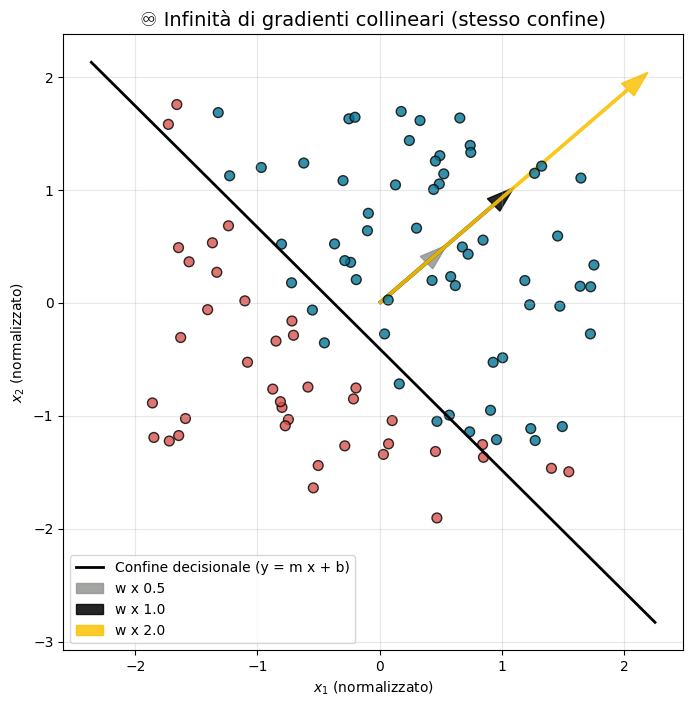

📊 OSSERVAZIONE:
• Tutti i vettori w disegnati sono paralleli (collineari).
• Definiscono la stessa retta, perché f(x) = 0 e c·f(x) = 0 hanno lo stesso insieme di soluzioni.
• Cambiando la scala, si modifica solo la lunghezza del gradiente.
• Di conseguenza:
    - Il margine funzionale γ_i = t_i (w^T x_i + w0) cambia.
    - Il margine geometrico γ̂_i = γ_i / ||w|| resta invariato.

📏 ESEMPIO SUL PRIMO PUNTO:
   x = [-1.848 -1.191],  t = -1
   Margine funzionale γ = 1.452
   Margine geometrico γ̂ = 1.889
   (Se riscalassimo w, γ cambierebbe ma γ̂ resterebbe uguale.)


In [ ]:
# ============================================================
# ♾️ Infinità di gradienti equivalenti (stessa direzione, diversa scala)
# ============================================================

print("\n===========================================")
print("♾️ INFNITÀ DI GRADIENTI EQUIVALENTI")
print("===========================================\n")

print("📘 Partiamo dal confine decisionale stimato con Least Squares:")
print(f"   {w1:.3f} * x1 + {w2:.3f} * x2 + {w0:.3f} = 0")
print()

print("🧭 Il gradiente (normale al confine) è:")
print(f"   ∇f = [w1, w2] = [{w1:.3f}, {w2:.3f}]")
print(f"   Direzione unitaria (verso normalizzato): {grad_norm.round(3)}")
print()

print("💡 Possiamo moltiplicare l'intera equazione per una costante c ≠ 0 senza cambiare la retta.")
print("   → Tutti i vettori w' = c·w hanno la stessa direzione (stesso orientamento).")
print("   → Cambia solo la lunghezza (cioè la norma ||w'||).")
print()

# Definizione di tre scale diverse
scales = [0.5, 1.0, 2.0]
colors_grad = ['xkcd:gray', 'xkcd:black', 'xkcd:goldenrod']

print("🔹 Generiamo tre versioni del gradiente:")
for c in scales:
    w_scaled = grad_norm * c
    print(f"   - scala c = {c:>3.1f} → w' = {np.round(w_scaled, 3)} | ||w'|| = {np.linalg.norm(w_scaled):.3f}")
print()

# ------------------------------------------------------------
# Visualizzazione grafica
# ------------------------------------------------------------
plt.figure(figsize=(8, 8))
plt.plot(xx, yy, 'k-', linewidth=2, label='Confine decisionale (y = m x + b)')

# Disegna i gradienti scalati
for scale, col in zip(scales, colors_grad):
    w_scaled = grad_norm * scale
    plt.arrow(x_center, y_center,
              w_scaled[0]*1.5, w_scaled[1]*1.5,
              color=col, width=0.02, head_width=0.15,
              alpha=0.85, length_includes_head=True,
              label=f"w x {scale}")

# Punti del dataset
plt.scatter(X_norm[:, 0], X_norm[:, 1],
            c=[colors[int(i)] for i in y_ls],
            s=50, edgecolor='k', alpha=0.8)

plt.title("♾️ Infinità di gradienti collineari (stesso confine)", fontsize=14)
plt.xlabel("$x_1$ (normalizzato)")
plt.ylabel("$x_2$ (normalizzato)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# Analisi numerica finale
# ------------------------------------------------------------
print("📊 OSSERVAZIONE:")
print("• Tutti i vettori w disegnati sono paralleli (collineari).")
print("• Definiscono la stessa retta, perché f(x) = 0 e c·f(x) = 0 hanno lo stesso insieme di soluzioni.")
print("• Cambiando la scala, si modifica solo la lunghezza del gradiente.")
print("• Di conseguenza:")
print("    - Il margine funzionale γ_i = t_i (w^T x_i + w0) cambia.")
print("    - Il margine geometrico γ̂_i = γ_i / ||w|| resta invariato.\n")

# Esempio numerico su un punto
x_sample = X_norm[0]
t_sample = 1 if y_ls[0] == 1 else -1
gamma_func = t_sample * (w1*x_sample[0] + w2*x_sample[1] + w0)
gamma_geom = gamma_func / np.linalg.norm([w1, w2])
print(f"📏 ESEMPIO SUL PRIMO PUNTO:")
print(f"   x = {x_sample.round(3)},  t = {t_sample}")
print(f"   Margine funzionale γ = {gamma_func:.3f}")
print(f"   Margine geometrico γ̂ = {gamma_geom:.3f}")
print("   (Se riscalassimo w, γ cambierebbe ma γ̂ resterebbe uguale.)")

### 🌿 Estensione non lineare del modello: feature quadratiche

Finora abbiamo visto come il classificatore ai **Minimi Quadrati** trovi un *confine decisionale lineare*,  
descritto da un’equazione del tipo:

$$
y_1(x) - y_2(x) = 0 \quad \Longleftrightarrow \quad w_1^\top x + b_1 = w_2^\top x + b_2.
$$

Tuttavia, molti problemi reali **non sono linearmente separabili** nello spazio originale delle feature.  
Una strategia naturale consiste allora nel **trasformare lo spazio dei dati** applicando una *funzione di base* $ \Phi(x) $,  
che genera **nuove feature non lineari** (ad esempio termini quadratici o misti):

$$
\Phi(x) = [1, x_1, x_2, x_1^2, x_2^2, x_1x_2].
$$

In questo nuovo spazio, il modello rimane **lineare nei parametri** — cioè la soluzione analitica $ W = (Φ^T Φ)^{-1} Φ^T T $ è ancora valida —  ma il **confine decisionale proiettato nello spazio originale** diventa **non lineare** (una curva o superficie).

💡 In altre parole:
> anche se il modello è *linear regression in Φ(x)*,  
> la decision boundary è *non lineare in x*.

Nel blocco seguente estenderemo il modello Least Squares a questa base quadratica e visualizzeremo il nuovo **confine decisionale** (dove $ y_1(x) = y_2(x) $), che non sarà più una retta ma una curva che si adatta meglio ai dati.

✅ Accuracy (Least Squares Quadratico): 0.980
📐 Matrice dei pesi W_quad:
[[ 0.213  0.787]
 [-0.273  0.273]
 [-0.265  0.265]
 [ 0.08  -0.08 ]
 [ 0.102 -0.102]
 [ 0.012 -0.012]]


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


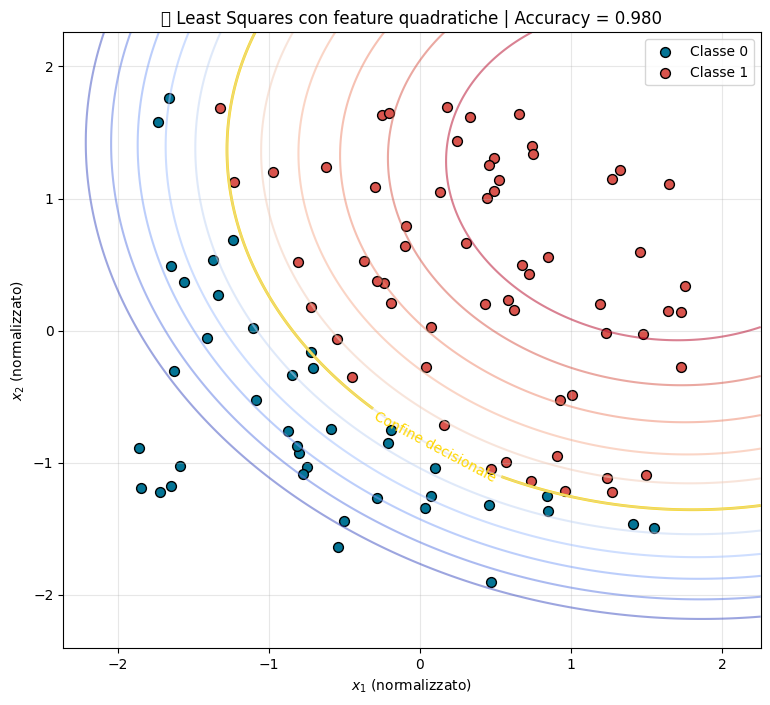


🧠 Analisi:
• Ora la base Φ(x) include anche termini quadrati e misti (x₁², x₂², x₁x₂).
• Il confine decisionale Z=0 non è più una retta, ma una curva (in genere un'ellisse o iperbole).
• Questo mostra come un modello lineare nei parametri W possa produrre decisioni non lineari nello spazio di input.


In [ ]:
# ============================================================
# 🧩 Least Squares con Feature Quadratiche (base non lineare)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ Funzione di base Φ(x): aggiungiamo termini quadratici
# ------------------------------------------------------------
def design_matrix_quadratic(X):
    """
    Genera una matrice Φ(X) con:
    [1, x1, x2, x1², x2², x1*x2]
    """
    x1, x2 = X[:, 0], X[:, 1]
    Phi = np.column_stack([
        np.ones(len(X)),   # bias
        x1,
        x2,
        x1**2,
        x2**2,
        x1 * x2
    ])
    return Phi

# Matrice Φ(X)
Phi_ls = design_matrix_quadratic(X_norm)

# ------------------------------------------------------------
# 2️⃣ Calcolo dei pesi (stesso schema dei minimi quadrati)
# ------------------------------------------------------------
W_quad = np.linalg.inv(Phi_ls.T @ Phi_ls) @ Phi_ls.T @ T

# Predizione continua
Y_pred_quad = Phi_ls @ W_quad
y_class_quad = np.argmax(Y_pred_quad, axis=1)

# Accuracy
acc_quad = np.mean(y_class_quad == y_ls)
print(f"✅ Accuracy (Least Squares Quadratico): {acc_quad:.3f}")
print("📐 Matrice dei pesi W_quad:")
print(W_quad.round(3))

# ------------------------------------------------------------
# 3️⃣ Griglia per visualizzare il confine decisionale
# ------------------------------------------------------------
x1_range = np.linspace(X_norm[:, 0].min() - 0.5, X_norm[:, 0].max() + 0.5, 200)
x2_range = np.linspace(X_norm[:, 1].min() - 0.5, X_norm[:, 1].max() + 0.5, 200)
xx, yy = np.meshgrid(x1_range, x2_range)

# Flatten e costruisci Φ per la griglia
grid_points = np.column_stack([xx.ravel(), yy.ravel()])
Phi_grid = design_matrix_quadratic(grid_points)

# Predizione sul piano
Y_grid = Phi_grid @ W_quad
Z = (Y_grid[:, 1] - Y_grid[:, 0]).reshape(xx.shape)  # differenza tra classi

# ------------------------------------------------------------
# 4️⃣ Visualizzazione dei risultati
# ------------------------------------------------------------
plt.figure(figsize=(9, 8))

# Scatter dei punti originali
for label, color in zip([0, 1], colors):
    plt.scatter(X_norm[y_ls == label, 0], X_norm[y_ls == label, 1],
                color=color, edgecolor='k', s=50, label=f"Classe {label}")

# Contour del confine decisionale (dove y1 = y2 → Z = 0)
contour = plt.contour(xx, yy, Z, levels=[0], colors=['gold'], linewidths=2)
plt.clabel(contour, fmt='Confine decisionale', inline=True, fontsize=10)

# Aggiunge anche isolinee per capire la forma
plt.contour(xx, yy, Z, levels=np.linspace(-1, 1, 11), cmap='coolwarm', alpha=0.5)

plt.title(f"🔮 Least Squares con feature quadratiche | Accuracy = {acc_quad:.3f}")
plt.xlabel("$x_1$ (normalizzato)")
plt.ylabel("$x_2$ (normalizzato)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# 5️⃣ Analisi
# ------------------------------------------------------------
print("\n🧠 Analisi:")
print("• Ora la base Φ(x) include anche termini quadrati e misti (x₁², x₂², x₁x₂).")
print("• Il confine decisionale Z=0 non è più una retta, ma una curva (in genere un'ellisse o iperbole).")
print("• Questo mostra come un modello lineare nei parametri W possa produrre decisioni non lineari nello spazio di input.")

## ⚙️ Il Percettrone: classificatore lineare e apprendimento iterativo

Il **Percettrone** (Rosenblatt, 1962) è uno dei primi modelli di **classificazione lineare** e rappresenta un punto di partenza storico per la moderna teoria dell’apprendimento automatico.

---

### 🧭 Obiettivo

Dato un insieme di dati di addestramento:
$$
\mathscr{D} = \{ (x_n, t_n) \}_{n=1}^N, \quad t_n \in \{-1, +1\},
$$

il percettrone cerca un **iperpiano lineare** che separi le due classi:
$$
y(x) = f(w^T x + b),
$$

dove:
- $w$ è il vettore dei **pesi**,
- $b$ è il **bias** (termine costante),
- $f(a)$ è una **funzione a gradino**:

$$
f(a) =
\begin{cases}
+1 & \text{se } a \ge 0, \\
-1 & \text{se } a < 0.
\end{cases}
$$

Il punto appartiene alla **classe $+1$** se cade nel semispazio dove $w^T x + b > 0$,
alla **classe $-1$** altrimenti.

---

### 🔍 Funzione obiettivo

Per ogni campione vogliamo che:
$$
t_n (w^T x_n) > 0.
$$

Se un punto è **mal classificato**, allora $t_n (w^T x_n) < 0$.  
Il **criterio del percettrone** penalizza solo questi punti, definendo la seguente funzione di errore:

$$
E_P(w) = - \sum_{n \in \mathscr{M}} t_n \, w^T x_n,
$$

dove $\mathscr{M}$ è l’insieme dei pattern mal classificati.

---

### 🔄 Regola di aggiornamento (Perceptron Learning Rule)

Applicando **discesa del gradiente stocastica** all’errore $E_P(w)$ si ottiene la regola di aggiornamento:

$$
w^{(\tau+1)} = w^{(\tau)} + \eta \, t_n \, x_n,
$$

dove:
- $\eta$ è il **learning rate** (tasso di apprendimento),
- $\tau$ indica l’iterazione corrente.

💡 In pratica:
- se un punto è **correttamente classificato**, i pesi non cambiano;
- se è **mal classificato**, il vettore $x_n$ viene **aggiunto** o **sottratto** a $w$,
  spostando il confine decisionale nella direzione giusta.

---

### 🧩 Procedura dell’algoritmo

1. Inizializza i pesi $w$ con valori piccoli casuali.  
2. Per ogni punto $(x_n, t_n)$:
   - calcola $y_n = \text{sign}(w^T x_n)$  
   - se $y_n \neq t_n$, aggiorna $w \leftarrow w + \eta \, t_n x_n$
3. Ripeti fino a convergenza o fino a un numero massimo di epoche.

---

### 📘 Teorema di convergenza

Il **teorema di convergenza del percettrone** afferma che:
> Se il dataset è *linearmente separabile*, l’algoritmo del percettrone converge
> in un numero finito di passi a una soluzione esatta.

Tuttavia:
- se i dati **non sono linearmente separabili**, l’algoritmo **non converge**;
- l’iperpiano trovato **non è unico** e dipende dall’ordine dei dati e dai valori iniziali.

---

### 📈 Limiti principali

- Il modello produce **decisioni deterministiche** (non probabilità).  
- È sensibile ai **dati anomali (outlier)** e (più importante) **dati non separabili linearmente**.  
- Non può gestire in modo naturale **più di due classi**.

Nella prossima sezione implementeremo il **Percettrone su dati reali** e visualizzeremo la frontiera di decisione.

🧮 Epoca mostrata: 10
📐 Gradiente (non normalizzato): [0.7747551  0.58367279]
🧭 Direzione del gradiente (unitaria): [0.79870837 0.60171833]
✅ Accuracy attuale: 0.869


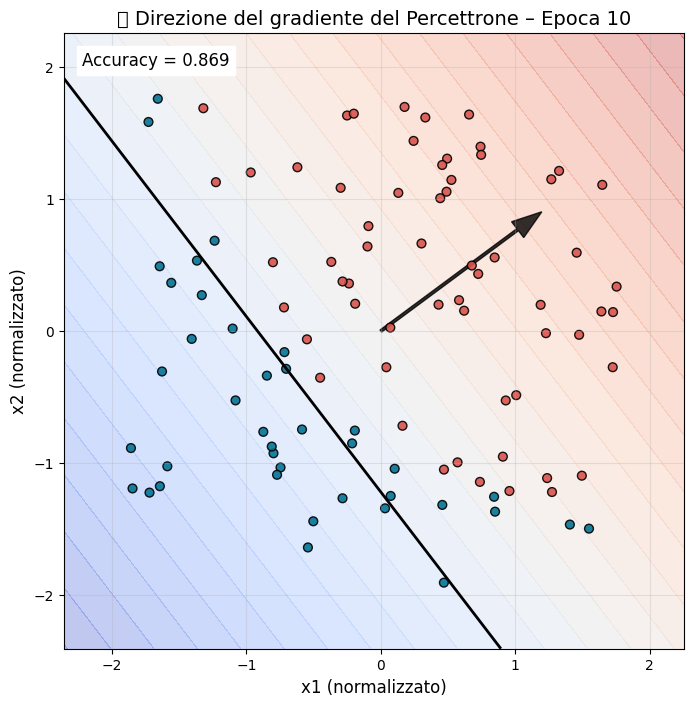

In [ ]:
# ============================================================
# ⚙️ Addestramento del Percettrone (versione stocastica)
# ============================================================

# Imposta i parametri di apprendimento
eta = 0.25                 # learning rate
epochs = 20                # numero di epoche
theta = np.random.rand(3, 1) * 0.1 - 0.05   # inizializzazione casuale (3 = bias + 2 feature)

# Lista per tenere traccia dell’evoluzione dei pesi
thetas = [theta.copy()]

# ============================================================
# 🔄 Ciclo di apprendimento (un campione alla volta)
# ============================================================
n = len(t)
for epoch in range(epochs):
    for i in range(n):
        # Calcola la predizione per il singolo campione
        y_i = 1 if np.dot(X_aug[i], theta) > 0 else 0
        # Aggiornamento solo se mal classificato
        theta += eta * (t[i] - y_i) * X_aug[i].reshape(-1, 1)
    # Salva i pesi dopo ogni epoca
    thetas.append(theta.copy())

# Seleziona l’epoca da visualizzare
k = min(10, len(thetas) - 1)  # ad esempio la decima epoca
theta = thetas[k]

# Calcola l'accuratezza corrente
y_pred = np.where(np.dot(X_aug, theta) > 0, 1, 0)
accuracy = np.mean(y_pred == t)

# ============================================================
# 🧭 Visualizzazione del gradiente (direzione del vettore w)
# ============================================================
grad = theta[1:].ravel()
grad_dir = grad / np.linalg.norm(grad)

print(f"🧮 Epoca mostrata: {k}")
print("📐 Gradiente (non normalizzato):", grad)
print("🧭 Direzione del gradiente (unitaria):", grad_dir)
print(f"✅ Accuracy attuale: {accuracy:.3f}")

# Punto di partenza (centro del piano)
x_center = np.mean(X_norm[:, 0])
y_center = np.mean(X_norm[:, 1])

# Griglia per lo sfondo colorato
x_min, x_max = X_norm[:, 0].min() - 0.5, X_norm[:, 0].max() + 0.5
y_min, y_max = X_norm[:, 1].min() - 0.5, X_norm[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid_aug = np.column_stack((-np.ones(xx.size), xx.ravel(), yy.ravel()))
zz = np.dot(grid_aug, theta).reshape(xx.shape)

# ------------------------------------------------------------
# Plot con la freccia del gradiente
# ------------------------------------------------------------
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, zz, levels=30, cmap='coolwarm', alpha=0.35)
plt.contour(xx, yy, zz, levels=[0], colors='k', linewidths=2)

# Freccia del gradiente
plt.arrow(x_center, y_center,
          grad_dir[0] * 1.5, grad_dir[1] * 1.5,
          color='black', width=0.02, head_width=0.15,
          alpha=0.8, length_includes_head=True)

# Punti del dataset
plt.scatter(X_norm[:, 0], X_norm[:, 1],
            c=[colors[i] for i in t.ravel()],
            s=40, edgecolor='k', alpha=0.9)

plt.xlabel("x1 (normalizzato)", fontsize=12)
plt.ylabel("x2 (normalizzato)", fontsize=12)
plt.title(f"🧭 Direzione del gradiente del Percettrone – Epoca {k}", fontsize=14)

# Box con accuracy
plt.annotate(f"Accuracy = {accuracy:.3f}",
             xy=(0.03, 0.97),
             xycoords='axes fraction',
             va='top',
             fontsize=12,
             backgroundcolor='white')

plt.grid(alpha=0.3)
plt.show()

## 📉 Analisi della convergenza e stabilità del Percettrone

Il **perceptrone** apprende iterativamente modificando il vettore dei pesi $w$
ogni volta che un campione è **mal classificato**.  
Tuttavia, questo processo non garantisce una convergenza stabile, soprattutto se i dati **non sono linearmente separabili**.

---

### ⚙️ Comportamento durante l’apprendimento

Ad ogni iterazione $k$ il modello aggiorna i pesi secondo la regola:

$$
w^{(k+1)} = w^{(k)} + \eta (t_n - y_n) x_n
$$

dove $t_n$ è l’etichetta vera e $y_n$ la predizione.  
Questo può migliorare la classificazione di un punto, ma **peggiorare quella di altri**.

---

### 📈 Evoluzione dell’accuratezza

Tracciando l’**accuratezza ad ogni iterazione**, possiamo osservare che il valore tende a **fluttuare**:
- in un dataset **linearmente separabile**, il valore converge a 1.0 (classificazione perfetta);  
- in un dataset **non separabile**, l’accuratezza resta **instabile**, oscillando attorno a un valore medio.

---

### 🌀 Frontiera decisionale nel tempo

Mostrando la **retta di separazione** ogni 10 iterazioni,
si vede come l’iperpiano (la linea di decisione) **si sposta continuamente**:
ogni aggiornamento tende a correggere errori locali, generando movimenti irregolari.

Questo comportamento evidenzia una **debolezza fondamentale** del percettrone:
> non essendo basato su un criterio probabilistico né su una funzione di errore liscia,
> l’apprendimento può risultare instabile e non convergere mai pienamente.

---

👉 Nella prossima sezione introdurremo un approccio **probabilistico** —  
il **Gaussian Discriminant Analysis (GDA)** — che risolve molti di questi problemi,  
fornendo confini decisionali più stabili e interpretabili.

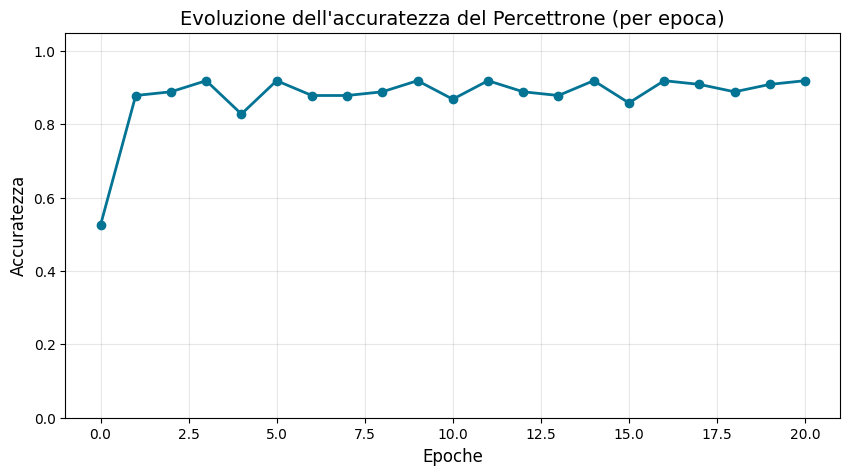

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


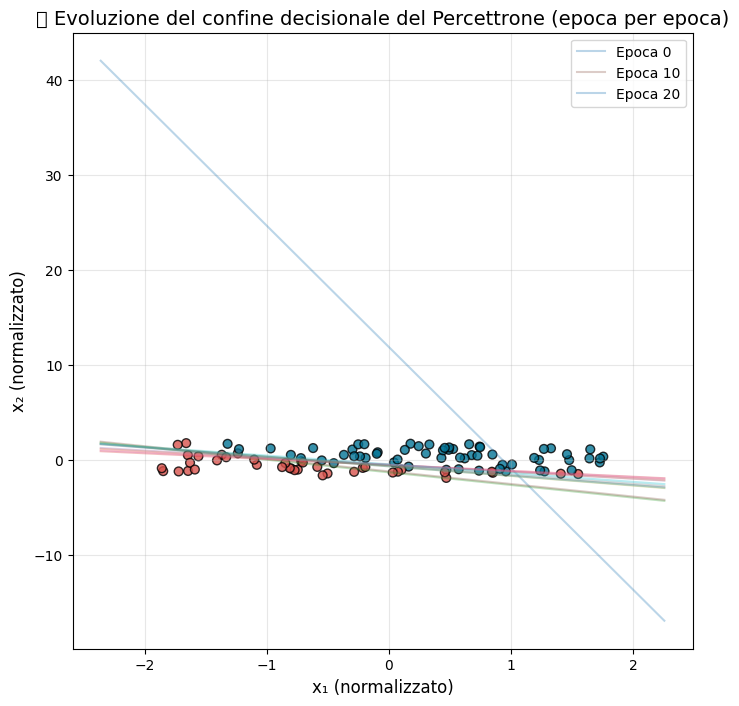

In [ ]:
# ============================================================
# 📉 Evoluzione dell’accuratezza del Percettrone (versione stocastica)
# ============================================================

# Funzione per calcolare l'accuratezza su tutto il dataset
def accuracy_score(theta, X, t):
    y_pred = np.where(np.dot(X, theta) > 0, 1, 0)
    return np.mean(y_pred == t)

# Calcola l’accuratezza dopo ogni epoca
accuracies = np.array([accuracy_score(th, X_aug, t) for th in thetas])

# ------------------------------------------------------------
# 🔍 Plot dell’evoluzione dell’accuratezza
# ------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(range(len(accuracies)), accuracies, color='xkcd:sea blue', linewidth=2, marker='o')
plt.title("Evoluzione dell'accuratezza del Percettrone (per epoca)", fontsize=14)
plt.xlabel("Epoche", fontsize=12)
plt.ylabel("Accuratezza", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 🌀 Evoluzione del confine decisionale (dataset originale)
# ============================================================

plt.figure(figsize=(8, 8))

# Colori per le classi (0 e 1)
colors = ['xkcd:pale red', 'xkcd:sea blue']
plt.scatter(X_norm[:, 0], X_norm[:, 1],
            c=[colors[int(i)] for i in t.ravel()],
            s=40, edgecolor='k', alpha=0.8)

# Range per x1
xx = np.linspace(X_norm[:, 0].min() - 0.5, X_norm[:, 0].max() + 0.5, 100)

# Disegna la retta di separazione ogni 2 epoche
for epoch in range(0, len(thetas), 2):
    th = thetas[epoch]
    # Evita divisioni per zero (retta verticale)
    if np.abs(th[2]) < 1e-6:
        continue
    theta1 = -th[1] / th[2]
    theta0 = th[0] / th[2]
    yy = theta0 + theta1 * xx
    plt.plot(xx, yy, alpha=0.3, linewidth=1.5,
             label=f"Epoca {epoch}" if epoch % 10 == 0 else None)

plt.title("🌀 Evoluzione del confine decisionale del Percettrone (epoca per epoca)", fontsize=14)
plt.xlabel("x₁ (normalizzato)", fontsize=12)
plt.ylabel("x₂ (normalizzato)", fontsize=12)
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

# 🌈 Gaussian Discriminant Analysis (GDA)

Dopo aver analizzato i modelli discriminativi lineari — **Percettrone** e **Least Squares** — introduciamo ora un approccio **probabilistico** alla classificazione:  
la **Gaussian Discriminant Analysis (GDA)**.

---

## 🔹 Idea di base

Si assume che i dati di ciascuna classe $ C_k $ provengano da una **distribuzione gaussiana multivariata**:

$$
p(\mathbf{x} | C_k) = \frac{1}{(2\pi)^{D/2} |\Sigma_k|^{1/2}}
\exp\!\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_k)^{\mathrm{T}} \Sigma_k^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) \right)
$$

dove:
- $ \boldsymbol{\mu}_k $ è la media della classe $ C_k $,
- $ \Sigma_k $ è la matrice di covarianza della classe $ C_k $.

---

## 🔹 Classificazione bayesiana

Utilizzando la **regola di Bayes**, possiamo stimare la probabilità a posteriori di ciascuna classe:

$$
p(C_k | \mathbf{x}) = \frac{p(\mathbf{x} | C_k) \, p(C_k)}{p(\mathbf{x})}
$$

Il denominatore $ p(\mathbf{x}) $ è identico per tutte le classi, quindi ai fini della decisione possiamo confrontare direttamente le **funzioni discriminanti**:

$$
g_k(\mathbf{x}) = \ln p(\mathbf{x} | C_k) + \ln p(C_k)
$$

Il punto viene assegnato alla classe che massimizza $ g_k(\mathbf{x}) $.

---

## 🔹 Assunzione di covarianza condivisa

Un caso particolarmente utile (e comune) è quello in cui tutte le classi condividono la **stessa covarianza**:

$$
\Sigma_k = \Sigma, \quad \forall k
$$

In tal caso, la funzione discriminante diventa **lineare** in $ \mathbf{x} $:

$$
g_k(\mathbf{x}) = \mathbf{w}_k^{\mathrm{T}} \mathbf{x} + w_{k0}
$$

con

$$
\mathbf{w}_k = \Sigma^{-1} \boldsymbol{\mu}_k, \quad
w_{k0} = -\frac{1}{2} \boldsymbol{\mu}_k^{\mathrm{T}} \Sigma^{-1} \boldsymbol{\mu}_k + \ln p(C_k)
$$

---

## 🔹 Decisione finale

Nel caso binario ($ K = 2 $), possiamo riscrivere la funzione discriminante in forma *logistica*:

$$
p(C_1 | \mathbf{x}) =
\sigma(\mathbf{w}^{\mathrm{T}} \mathbf{x} + w_0)
$$

dove $ \sigma(a) = \frac{1}{1 + e^{-a}} $ è la **sigmoide logistica**, e

$$
\mathbf{w} = \Sigma^{-1} (\boldsymbol{\mu}_1 - \boldsymbol{\mu}_0), \quad
w_0 = -\frac{1}{2}(\boldsymbol{\mu}_1^{\mathrm{T}} \Sigma^{-1} \boldsymbol{\mu}_1 -
\boldsymbol{\mu}_0^{\mathrm{T}} \Sigma^{-1} \boldsymbol{\mu}_0) + \ln \frac{p(C_1)}{p(C_0)}
$$

---

## 🔹 Interpretazione geometrica

- Il **confine decisionale** è una retta (in 2D) o un iperpiano (in generale), come nel Percettrone e nel Least Squares.  
- Tuttavia, qui il confine rappresenta i punti per cui $ p(C_1 | \mathbf{x}) = p(C_0 | \mathbf{x}) = 0.5 $.  
- La **decisione** è quindi probabilistica: possiamo anche stimare *quanto* un punto appartiene a una classe.

---

Nel blocco seguente implementiamo la **GDA** sullo stesso dataset per confrontarla con il Percettrone e il modello ai minimi quadrati. 👇

📊 Parametri stimati:

μ1 = [0.45390659 0.42135714]
μ2 = [-0.69831783 -0.64824175]

Σ =
[[ 0.68730466 -0.31448798]
 [-0.31448798  0.73149997]]

w = [2.91988863 2.71752406]
b = 1.096


/tmp/ipython-input-1133219245.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ell = Ellipse(xy=mu, width=width, height=height,


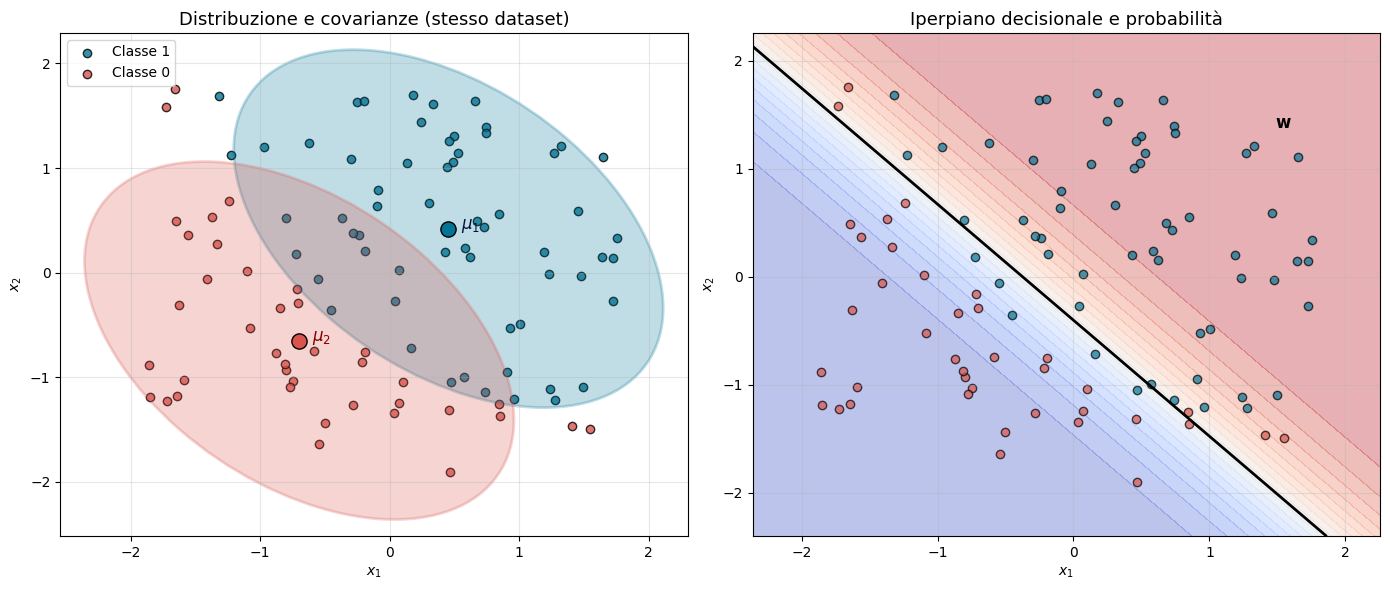

In [ ]:
# ============================================================
# 🧠 Gaussian Discriminant Analysis (GDA)
#     - Probabilistic version of the Perceptron
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid  # logistic sigmoid
from matplotlib.patches import Ellipse

# ------------------------------------------------------------
# 1️⃣ Dataset: stessi dati normalizzati del Percettrone
# ------------------------------------------------------------
X = X_norm                      # features (già normalizzate)
y = t.ravel().astype(int)       # target come array 1D di interi (0 o 1)

# ------------------------------------------------------------
# 2️⃣ Stima dei parametri del modello generativo
# ------------------------------------------------------------
mu1 = np.mean(X[y == 1], axis=0)
mu2 = np.mean(X[y == 0], axis=0)

# Covarianza condivisa Σ
n1, n2 = np.sum(y == 1), np.sum(y == 0)
S1 = np.cov(X[y == 1].T)
S2 = np.cov(X[y == 0].T)
Sigma = (n1 * S1 + n2 * S2) / (n1 + n2)

# Inversa e priors
Sigma_inv = np.linalg.inv(Sigma)
p1, p2 = n1 / (n1 + n2), n2 / (n1 + n2)

# ------------------------------------------------------------
# 3️⃣ Parametri del modello discriminante
# ------------------------------------------------------------
w = Sigma_inv @ (mu1 - mu2)
b = -0.5 * (mu1.T @ Sigma_inv @ mu1 - mu2.T @ Sigma_inv @ mu2) + np.log(p1 / p2)

print("📊 Parametri stimati:\n")
print(f"μ1 = {mu1}")
print(f"μ2 = {mu2}")
print(f"\nΣ =\n{Sigma}")
print(f"\nw = {w}")
print(f"b = {b:.3f}")

# ------------------------------------------------------------
# 4️⃣ Classificatore probabilistico
# ------------------------------------------------------------
def predict_proba(X):
    """Restituisce p(C1 | x)"""
    return sigmoid(X @ w + b)

def predict(X):
    """Classe più probabile"""
    return (predict_proba(X) >= 0.5).astype(int)

# ------------------------------------------------------------
# 5️⃣ Griglia per il calcolo di p(C1|x)
# ------------------------------------------------------------
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = predict_proba(grid).reshape(xx.shape)

# ------------------------------------------------------------
# 6️⃣ Visualizzazione – doppio pannello
# ------------------------------------------------------------
def plot_cov_ellipse(ax, mu, Sigma, color, alpha=0.25, scale=2.0):
    """Disegna un’ellisse che rappresenta la covarianza Σ attorno a μ."""
    vals, vecs = np.linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * scale * np.sqrt(vals)
    ell = Ellipse(xy=mu, width=width, height=height,
                  angle=theta, color=color, alpha=alpha, lw=2, edgecolor="k")
    ax.add_patch(ell)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ==== Pannello 1: distribuzione e covarianze ====
ax = axes[0]
ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1],
           color="xkcd:sea blue", label="Classe 1", edgecolor="k", alpha=0.8)
ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1],
           color="xkcd:pale red", label="Classe 0", edgecolor="k", alpha=0.8)
plot_cov_ellipse(ax, mu1, Sigma, color="xkcd:sea blue")
plot_cov_ellipse(ax, mu2, Sigma, color="xkcd:pale red")

ax.scatter(mu1[0], mu1[1], s=120, c="xkcd:sea blue", edgecolor="k", marker="o")
ax.scatter(mu2[0], mu2[1], s=120, c="xkcd:pale red", edgecolor="k", marker="o")
ax.text(mu1[0]+0.1, mu1[1], r"$\mu_1$", fontsize=12, color="xkcd:navy", weight="bold")
ax.text(mu2[0]+0.1, mu2[1], r"$\mu_2$", fontsize=12, color="xkcd:dark red", weight="bold")

ax.set_title("Distribuzione e covarianze (stesso dataset)", fontsize=13)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend(loc="upper left")
ax.grid(alpha=0.3)

# ==== Pannello 2: iperpiano e probabilità ====
ax = axes[1]
ax.contourf(xx, yy, probs, cmap="coolwarm", alpha=0.35, levels=np.linspace(0, 1, 20))
ax.contour(xx, yy, probs, levels=[0.5], colors="k", linewidths=2)
center = (mu1 + mu2) / 2
ax.text(center[0] + w[0]*0.55, center[1] + w[1]*0.55, "w", fontsize=12, fontweight="bold")

ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1],
           color="xkcd:sea blue", edgecolor="k", alpha=0.7)
ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1],
           color="xkcd:pale red", edgecolor="k", alpha=0.7)

ax.set_title("Iperpiano decisionale e probabilità", fontsize=13)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 🌪️ Gaussian Discriminant Analysis con covarianze diverse (Σ₁ ≠ Σ₂)

Finora abbiamo assunto che le due classi condividessero la stessa matrice di covarianza:
$$
\Sigma_1 = \Sigma_2 = \Sigma
$$
ottenendo un **confine decisionale lineare**.

Ora rilassiamo questa ipotesi e stimiamo una **matrice di covarianza diversa per ciascuna classe**.  
In tal caso, le funzioni discriminanti diventano:

$$
g_k(x) = -\frac{1}{2} (x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k)
         - \frac{1}{2} \ln |\Sigma_k| + \ln p(C_k)
$$

Imponendo $g_1(x) = g_2(x)$ si ottiene un **confine decisionale quadratico** —  
una curva che separa le regioni dove ciascuna distribuzione è più probabile.

📊 Parametri stimati (GDA con covarianze diverse):

μ1 = [0.45390659 0.42135714]
μ2 = [-0.69831783 -0.64824175]

Σ1 =
 [[ 0.59688573 -0.22392769]
 [-0.22392769  0.73802936]]

Σ2 =
 [[ 0.82641071 -0.4538115 ]
 [-0.4538115   0.72145474]]


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127786 (\N{CLOUD WITH TORNADO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


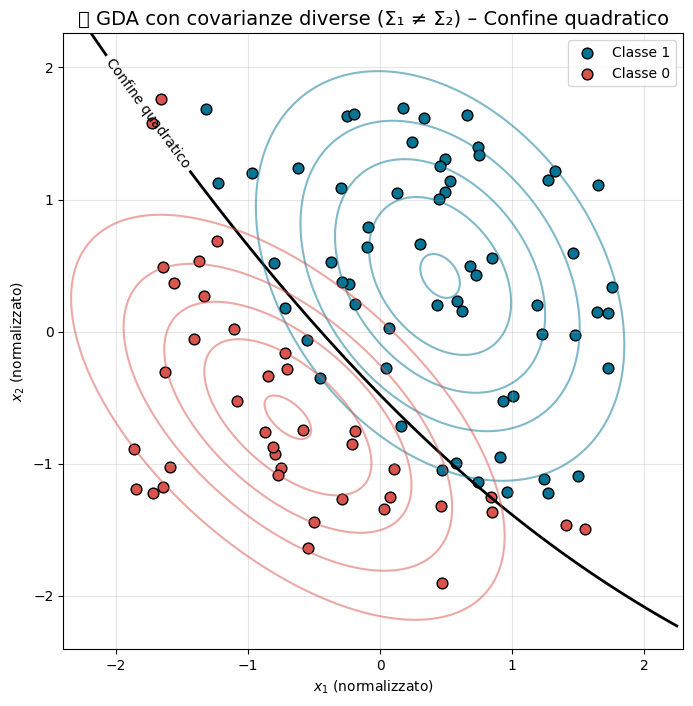

In [ ]:
# ============================================================
# 🌪️ GDA con covarianze diverse (Σ1 ≠ Σ2) – stesso dataset reale
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# ------------------------------------------------------------
# 1️⃣ Stima separata delle covarianze per ciascuna classe
# ------------------------------------------------------------
mu1 = np.mean(X[y == 1], axis=0)
mu2 = np.mean(X[y == 0], axis=0)
Sigma1 = np.cov(X[y == 1].T)
Sigma2 = np.cov(X[y == 0].T)

p1, p2 = np.mean(y == 1), np.mean(y == 0)

print("📊 Parametri stimati (GDA con covarianze diverse):\n")
print(f"μ1 = {mu1}")
print(f"μ2 = {mu2}")
print("\nΣ1 =\n", Sigma1)
print("\nΣ2 =\n", Sigma2)

# ------------------------------------------------------------
# 2️⃣ Griglia di valutazione (stesso range del dataset)
# ------------------------------------------------------------
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# ------------------------------------------------------------
# 3️⃣ Calcolo delle funzioni discriminanti
# ------------------------------------------------------------
logp1 = multivariate_normal.logpdf(grid, mean=mu1, cov=Sigma1) + np.log(p1)
logp2 = multivariate_normal.logpdf(grid, mean=mu2, cov=Sigma2) + np.log(p2)
Z = (logp1 - logp2).reshape(xx.shape)  # g1 - g2

# ------------------------------------------------------------
# 4️⃣ Visualizzazione
# ------------------------------------------------------------
plt.figure(figsize=(8, 8))

# Contour della frontiera decisionale (g1 = g2 → Z = 0)
contour = plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
plt.clabel(contour, fmt='Confine quadratico', inline=True, fontsize=10)

# Contour di probabilità per le due gaussiane
plt.contour(xx, yy,
            multivariate_normal.pdf(grid, mean=mu1, cov=Sigma1).reshape(xx.shape),
            levels=5, colors='xkcd:sea blue', alpha=0.5)
plt.contour(xx, yy,
            multivariate_normal.pdf(grid, mean=mu2, cov=Sigma2).reshape(xx.shape),
            levels=5, colors='xkcd:pale red', alpha=0.5)

# Punti originali del dataset
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1],
            color='xkcd:sea blue', edgecolor='k', s=60, label='Classe 1')
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1],
            color='xkcd:pale red', edgecolor='k', s=60, label='Classe 0')

plt.title("🌪️ GDA con covarianze diverse (Σ₁ ≠ Σ₂) – Confine quadratico", fontsize=14)
plt.xlabel("$x_1$ (normalizzato)")
plt.ylabel("$x_2$ (normalizzato)")
plt.legend()
plt.grid(alpha=0.3)
plt.axis('equal')
plt.show()

### 💬 Osservazioni

- Il confine nero non è più una **retta**, ma una **curva**: una forma quadratica (ellisse o iperbole).  
- Questo accade perché i termini quadratici $(x^T \Sigma_k^{-1} x)$ *non si cancellano più* tra le due classi.  
- Il modello risultante prende il nome di **Quadratic Discriminant Analysis (QDA)**.  
- La GDA lineare è quindi un caso particolare della QDA in cui $\Sigma_1 = \Sigma_2$.

# 🏁 Conclusioni: tre prospettive su un unico confine lineare

Abbiamo esplorato tre approcci diversi alla **classificazione lineare**, tutti riconducibili a un'unica forma generale di *decision boundary*:

$$
w^T x + w_0 = 0
$$

Tuttavia, il **modo in cui questo confine viene appreso e interpretato** cambia radicalmente a seconda del modello.

---

## 🔹 Percettrone — apprendimento iterativo e geometrico

- Nasce da una **visione puramente geometrica**: l’obiettivo è spostare l’iperpiano finché separa correttamente i punti.  
- Aggiorna i pesi solo quando un campione è **mal classificato**.  
- Il criterio di errore è **discreto e non derivabile**, quindi l’ottimizzazione non è continua.  
- Se i dati **sono linearmente separabili**, l’algoritmo converge in un numero finito di passi.  
- Tuttavia, su dati **non separabili**, il modello non converge e l’accuratezza oscilla.

📉 **Punti deboli:** mancanza di interpretazione probabilistica, sensibilità ai dati non lineari, e comportamento instabile.  
📈 **Forza:** estrema semplicità e interpretazione geometrica intuitiva.

---

## 🔹 Least Squares — la via analitica

- Riutilizza la **regressione lineare** per la classificazione.  
- La soluzione è ottenuta in forma **chiusa**:
  $$
  W = (X^T X)^{-1} X^T T
  $$
- Fornisce un iperpiano simile al Percettrone, ma basato su una **funzione di costo continua e derivabile**.  
- Tuttavia, il modello **non garantisce coerenza probabilistica**: le “probabilità” possono uscire da $[0, 1]$.  
- Inoltre è **molto sensibile agli outlier**, che spostano fortemente il confine.

⚠️ **Punti deboli:** mancanza di interpretazione probabilistica, scarsa robustezza.  
💡 **Forza:** soluzione esatta, utile per introdurre concetti di regressione e matrici.

---

## 🔹 Gaussian Discriminant Analysis — la visione probabilistica

- Assume che i dati di ciascuna classe provengano da una **distribuzione gaussiana multivariata**:
  $$
  p(x|C_k) = \mathscr{N}(x | \mu_k, \Sigma)
  $$
- Utilizzando la regola di Bayes, la decisione è basata sulla probabilità a posteriori:
  $$
  p(C_k | x) = \frac{p(x|C_k) p(C_k)}{p(x)}
  $$
- Con covarianze condivise ($\Sigma_1 = \Sigma_2$), il confine decisionale è **lineare**, ma ora ha un significato probabilistico:  
  ogni punto è classificato **secondo la probabilità** di appartenere a ciascuna classe.

🧩 **Forza:** fornisce una visione *generativa* coerente, interpretabile e stabile.  
🧠 **Limite:** richiede l’assunzione di gaussianità (non sempre realistica).

---

## ⚖️ Riflessione comparativa

| Aspetto | Percettrone | Least Squares | GDA |
|----------|--------------|----------------|------|
| **Tipo di modello** | Discriminativo (iterativo) | Discriminativo (analitico) | Generativo (probabilistico) |
| **Funzione di costo** | Discreta, non derivabile | Quadratica (MSE) | Log-verosimiglianza |
| **Interpretazione** | Geometrica | Algebra lineare | Probabilistica |
| **Stabilità** | Instabile su dati non separabili | Sensibile agli outlier | Stabile e coerente |
| **Decisione** | Segno di $w^T x$ | Segno di $w^T x$ | Posterior $p(C_1|x) > 0.5$ |
| **Probabilità** | ❌ No | ⚠️ Approssimata | ✅ Sì |
| **Estendibilità** | Difficile | Limitata | Naturale (multi-classe) |

---

## 🌌 Conclusione finale

I tre metodi mostrano come **la stessa forma funzionale** — un iperpiano lineare —  
possa derivare da **motivazioni completamente diverse**:

- dal **tentativo di correggere errori** (Percettrone),  
- dalla **minimizzazione di una distanza quadratica** (Least Squares),  
- o dalla **modellazione probabilistica delle classi** (GDA).

In altre parole:

> 🔸 *Il Percettrone guarda il confine.*  
> 🔹 *Il Least Squares guarda le distanze.*  
> 🔸 *La GDA guarda la distribuzione.*

---

📘 **Messaggio chiave:**  
Comprendere i legami tra modelli discriminativi e generativi è essenziale per capire  
come la probabilità, la geometria e l’ottimizzazione si incontrano nel cuore del *Machine Learning*.

----


# Appendice

## Appendice 1: 🧩 Il problema XOR e i limiti del Percettrone

Il **Percettrone** di Rosenblatt è un classificatore lineare:  
cerca una frontiera della forma

$$
w^T x + b = 0
$$

che separi due classi nello spazio delle feature.

Finché i dati sono **linearmente separabili**, l’algoritmo converge e trova un iperpiano corretto.  
Ma cosa succede se le classi **non sono separabili con una retta**?

---

### ⚙️ Il caso classico: XOR

Il problema **XOR** (*exclusive OR*) è un esempio emblematico:

| x₁ | x₂ | XOR(x₁, x₂) |
|----|----|--------------|
| 0  | 0  | 0 |
| 0  | 1  | 1 |
| 1  | 0  | 1 |
| 1  | 1  | 0 |

Non esiste **alcuna retta** che separi perfettamente i punti con output 0 da quelli con output 1.  
È necessario un **confine non lineare**, come due semipiani o una curva chiusa.

---

### ❌ Perché il Percettrone fallisce

Il Percettrone applica una funzione a soglia $ f(a) = \text{sign}(w^T x + b) $,  
e ogni aggiornamento modifica il vettore $ w $ per spostare la linea di separazione.

Tuttavia, se il problema non è linearmente separabile:

- l’algoritmo **non converge**;
- i pesi oscillano all’infinito;
- l’accuratezza resta inferiore a 100%.

Questo era esattamente il punto sollevato da **Minsky e Papert (1969)**:  
> “Il Percettrone, in quanto modello a singolo strato, non può risolvere nemmeno il problema XOR.”

Le loro critiche erano corrette — e portarono al cosiddetto **“AI Winter”**,  
ma anche a una consapevolezza fondamentale:  
> per risolvere problemi non lineari, servono **più strati di neuroni** e un metodo per addestrarli —  
> ciò che, anni dopo, diventerà il **backpropagation**.

---

### 🧠 Esperimento: il Percettrone sul problema XOR

Nel codice seguente, alleniamo un Percettrone semplice (con bias e due feature) sul dataset XOR.  
Vedremo che, anche dopo molte epoche, **l’algoritmo non riesce a trovare un confine corretto**.

📐 Pesi finali: [ 0.17640523 -0.35998428 -0.1021262 ]
✅ Accuracy finale: 0.5


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


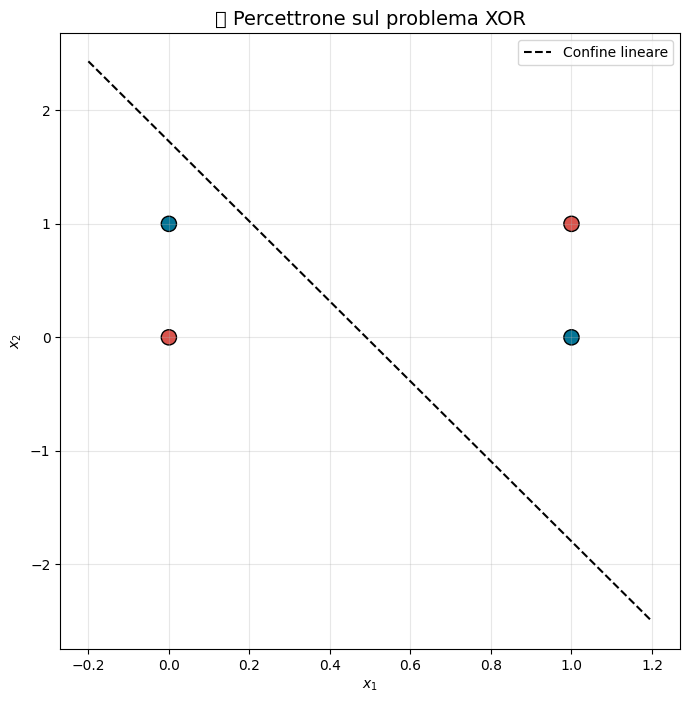

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


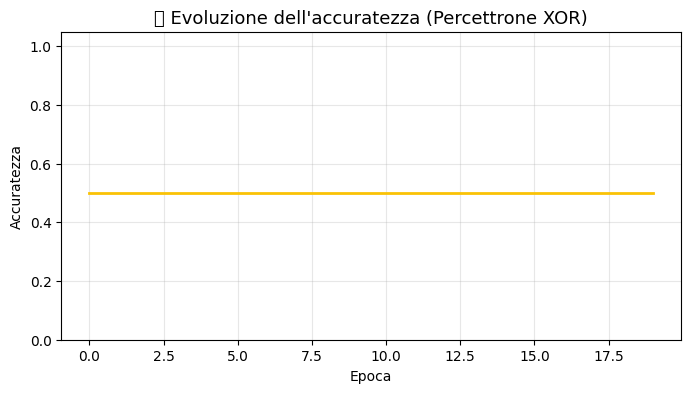

In [ ]:
# ============================================================
# ❌ Percettrone sul problema XOR (versione isolata, non interferisce)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ Dataset XOR (variabili locali)
# ------------------------------------------------------------
X_xor = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

y_xor = np.array([0, 1, 1, 0])

# Aggiunge il bias come prima colonna (1)
X_aug_xor = np.column_stack((np.ones(len(X_xor)), X_xor))

# ------------------------------------------------------------
# 2️⃣ Percettrone: inizializzazione e training
# ------------------------------------------------------------
np.random.seed(0)
w_xor = np.random.randn(3) * 0.1   # pesi casuali (bias + 2 feature)
eta = 0.2                          # learning rate
epochs = 20                        # numero di epoche

history_xor = []

for epoch in range(epochs):
    for i in range(len(X_aug_xor)):
        a = np.dot(w_xor, X_aug_xor[i])
        y_pred = 1 if a >= 0 else 0
        w_xor += eta * (y_xor[i] - y_pred) * X_aug_xor[i]
    # memorizza accuracy
    y_preds = (X_aug_xor @ w_xor >= 0).astype(int)
    acc = np.mean(y_preds == y_xor)
    history_xor.append(acc)

# ------------------------------------------------------------
# 3️⃣ Risultati numerici
# ------------------------------------------------------------
print("📐 Pesi finali:", w_xor)
print("✅ Accuracy finale:", history_xor[-1])

# ------------------------------------------------------------
# 4️⃣ Visualizzazione XOR
# ------------------------------------------------------------
plt.figure(figsize=(8, 8))
colors_xor = ['xkcd:pale red' if yi == 0 else 'xkcd:sea blue' for yi in y_xor]

plt.scatter(X_xor[:, 0], X_xor[:, 1], c=colors_xor, s=120, edgecolor='k')
plt.title("❌ Percettrone sul problema XOR", fontsize=14)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(alpha=0.3)

# Mostra il confine decisionale (se possibile)
x1_vals = np.linspace(-0.2, 1.2, 100)
if w_xor[2] != 0:
    x2_vals = -(w_xor[1] * x1_vals + w_xor[0]) / w_xor[2]
    plt.plot(x1_vals, x2_vals, 'k--', label="Confine lineare")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 5️⃣ Evoluzione dell'accuratezza
# ------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(history_xor, color='xkcd:goldenrod', linewidth=2)
plt.title("📉 Evoluzione dell'accuratezza (Percettrone XOR)", fontsize=13)
plt.xlabel("Epoca")
plt.ylabel("Accuratezza")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.show()

## Appendice 2: Verso l’idea di margine e la SVM

Abbiamo visto tre approcci diversi per costruire un classificatore lineare:

1. **Percettrone:** cerca una direzione di separazione qualsiasi,  
   ma può trovare *infinite* soluzioni equivalenti (diverse scale di $w$).  

2. **Minimi Quadrati:** trova un optimum in senso “numerico”,  
   ma non è pensato per classificare — penalizza anche i punti *troppo corretti*  
   perché si concentra sulla distanza verticale, non sulla separazione.  

3. **Metodo probabilistico (GDA o regressione logistica):**  
   cerca il piano che massimizza la probabilità di classificare correttamente i punti,  
   ma **non controlla la distanza dal confine**: può separare bene, ma con un margine stretto.

👉 Nelle prossime lezioni vedremo come risolvere tutti questi limiti:
un metodo che, come il Percettrone, cerca una separazione netta,
ma allo stesso tempo **massimizza la distanza dal confine**.  
Questa distanza è il **margine** — e sarà il cuore della *Support Vector Machine (SVM)*.

### 🧭 Il ruolo di $w$ e il concetto di margine (spoiler SVM)

In tutti i modelli lineari, la funzione discriminante ha la forma:

$$
y(x) = w^\top x + w_0
$$

Il vettore **$w$** definisce la **direzione ortogonale** al confine decisionale:
- la sua **direzione** indica l’orientamento della frontiera;
- la sua **norma** $‖w‖$ controlla “quanto ripida” è la separazione;
- il **bias** $w_0$ sposta il piano lungo tale direzione.

---

### 📏 Margine funzionale vs. margine geometrico

Ogni punto $x_i$ si trova a una certa distanza dal confine:

- **Margine funzionale:**
  $$
  \gamma_i = t_i (w^\top x_i + w_0)
  $$
  misura quanto fortemente un punto è classificato correttamente,  
  ma dipende dalla scala di $w$.

- **Margine geometrico:**
  $$
  \hat{\gamma}_i = \frac{\gamma_i}{‖w‖} = \frac{t_i (w^\top x_i + w_0)}{‖w‖}
  $$
  rappresenta la **vera distanza ortogonale** dal confine,  
  ed è **invariante** rispetto alla scala di $w$.

---

### 💡 Idea chiave

Molte combinazioni di $(w, w_0)$ producono **lo stesso confine decisionale**,  
ma **distanze diverse dai punti**: il margine geometrico cambia inversamente a $‖w‖$.

La **Support Vector Machine (SVM)** nasce proprio da qui:
> cerca il piano che separa le classi **massimizzando il margine geometrico**,  
> cioè minimizzando la norma di $w$.
